<a href="https://colab.research.google.com/github/marleyabe/Inferencia-PNS/blob/main/Artigo_PI_VI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [4]:
!pip install statsmodels
!pip install scikit-learn
!pip install causalinference
!pip install mord

In [5]:
import pandas as pd
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from causalinference import CausalModel
from sklearn.preprocessing import StandardScaler

from statsmodels.miscmodels.ordinal_model import OrderedModel

# Configurações

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.2f}'.format

# Importação dos Dados

In [8]:
df = pd.read_csv('/content/drive/MyDrive/IESB/PI VI/pns_2019.csv', low_memory=False)
df.head()

,sigla_uf,sigla_uf_sigla,sigla_uf_nome,V0024,UPA_PNS,V0006_PNS,V0020,V0031,C006,C008,C009,I00102,J012,J037,N001,P03201,P034,P035,P042,P050,Q00201,Q03001,Q060,Q06306,Q068,Q074,Q084,Q092,Q11006,VDD004A,VDF002,VDF003
0,12,AC,Acre,1210010,120003883,15,2019,Capital,Homem,17.00,Parda,não,10.00,não,NaN,não informado,não informado,NaN,NaN,NaN,não informado,não informado,não informado,não informado,não informado,não informado,não informado,não informado,não informado,Fundamental completo ou equivalente,89.00,22.00
1,12,AC,Acre,1210010,120008408,15,2019,Capital,Homem,24.00,Parda,não,NaN,não,NaN,não informado,não informado,NaN,NaN,NaN,não informado,não informado,não informado,não informado,não informado,não informado,não informado,não informado,não informado,Fundamental incompleto ou equivalente,1996.00,665.00
2,12,AC,Acre,1250010,120002870,5,2019,"Resto da UF (Unidade da Federação, excluindo a...",Homem,23.00,Parda,não,NaN,não,NaN,não informado,não informado,NaN,NaN,NaN,não informado,não informado,não informado,não informado,não informado,não informado,não informado,não informado,não informado,Médio completo ou equivalente,6460.00,2153.00
3,12,AC,Acre,1250020,120000201,4,2019,"Resto da UF (Unidade da Federação, excluindo a...",Mulher,21.00,Parda,não,1.00,não,NaN,não informado,não informado,NaN,NaN,NaN,não informado,não informado,não informado,não informado,não informado,não informado,não informado,não informado,não informado,Fundamental incompleto ou equivalente,1158.00,386.00
4,12,AC,Acre,1250020,120008232,3,2019,"Resto da UF (Unidade da Federação, excluindo a...",Homem,57.00,Preta,não,1.00,não,NaN,não informado,não informado,NaN,NaN,NaN,não informado,não informado,não informado,não informado,não informado,não informado,não informado,não informado,não informado,Sem instrução,1918.00,274.00


# Tratamento dos Dados

In [9]:
df.drop(['sigla_uf', 'sigla_uf_nome', 'V0020', 'V0006_PNS', 'UPA_PNS', 'VDF002'], axis=1, inplace=True)

In [10]:
df.rename(columns={'sigla_uf_sigla': 'uf',
                        'V0024': 'estrato',
                        'V0031': 'tipo_area',
                        'C006': 'sexo',
                        'C008': 'idade',
                        'C009': 'cor_raca',
                        'I00102': 'plano_saude', # Variável Alvo
                        'J012': 'qtd_consultas_12_meses',
                        'J037': 'internacoes_12_meses',
                        'N001': 'saude_subjetivo', # Variável de Análise
                        'P03201': 'alcool_30_dias',
                        'P034': 'atividade_fisica_3_meses',
                        'P035': 'atividade_fisica_por_semana',
                        'P042': 'atividade_fisica_deslocamento',
                        'P050': 'fumante',
                        'Q00201': 'hipertensao',
                        'Q03001': 'diagnostico_diabetes',
                        'Q060': 'diagnostico_colesterol',
                        'Q06306': 'doenca_cardiaca',
                        'Q068': 'avc',
                        'Q074': 'asma',
                        'Q084': 'dor_coluna',
                        'Q092': 'depressao',
                        'Q11006': 'ansiedade',
                        'VDD004A': 'instrucao',
                        'VDF003': 'renda_domiciliar_per_capita'
                        }, inplace=True)

In [11]:
df.replace('não informado', np.nan, inplace=True)

In [12]:
print('% de linhas vazias')
print((df.isnull().sum() / len(df)) * 100)

% de linhas vazias
uf                                0.00
estrato                           0.00
tipo_area                         0.00
sexo                              4.88
idade                             4.88
cor_raca                          4.88
plano_saude                       4.88
qtd_consultas_12_meses           29.74
internacoes_12_meses              4.88
saude_subjetivo                  69.07
alcool_30_dias                   87.94
atividade_fisica_3_meses         69.07
atividade_fisica_por_semana      87.61
atividade_fisica_deslocamento   100.00
fumante                          69.07
hipertensao                      69.79
diagnostico_diabetes             71.38
diagnostico_colesterol           71.78
doenca_cardiaca                  69.07
avc                              69.07
asma                             69.07
dor_coluna                       69.07
depressao                        69.07
ansiedade                        69.07
instrucao                        10.94
renda_

In [13]:
df.dropna(subset=df.columns[6:].tolist(), how='all', inplace=True)
print(df.shape)

(279382, 26)


In [14]:
for col in df.columns:
    if (df[col].isnull().sum() / len(df)) * 100 > 80:
        df.drop(col, axis=1, inplace=True)

print(df.shape)

(279382, 23)


In [15]:
df.dropna(thresh=len(df.columns) - 9, inplace=True)
df.shape

(90846, 23)

## Tratamento de Formatação

In [16]:
df['tipo_area'].replace('Resto da UF (Unidade da Federação, excluindo a região metropolitana e RIDE)', 'Resto da UF', inplace=True)
df['tipo_area'].replace('Resto da RM (Região Metropolitana, excluindo a capital)', 'Resto da RM', inplace=True)
df['tipo_area'].replace('RIDE (excluindo a capital)', 'RIDE', inplace=True)

In [17]:
df['instrucao'] = df['instrucao'].str.replace(' ou equivalente', '', regex=False)

In [18]:
df['idade'] = df['idade'].astype(int)
df['estrato'] = df['estrato'].astype(str)

## Transformando em Likert

In [19]:
df.replace('não', 0, inplace=True)
df.replace('sim', 1, inplace=True)

In [20]:
df['saude_subjetivo'].replace('Muito ruim', 0, inplace=True)
df['saude_subjetivo'].replace('Ruim', 1, inplace=True)
df['saude_subjetivo'].replace('Regular', 2, inplace=True)
df['saude_subjetivo'].replace('Boa', 3, inplace=True)
df['saude_subjetivo'].replace('Muito boa', 4, inplace=True)

In [21]:
df['fumante'].replace('Sim, diariamente', 1, inplace=True)
df['fumante'].replace('Sim, menos que diariamente', 1, inplace=True)
df['fumante'].replace('Não fumo atualmente', 0, inplace=True)

In [22]:
df['instrucao'].replace('Sem instrução', 0, inplace=True)
df['instrucao'].replace('Fundamental incompleto', 1, inplace=True)
df['instrucao'].replace('Fundamental completo', 2, inplace=True)
df['instrucao'].replace('Médio incompleto', 3, inplace=True)
df['instrucao'].replace('Médio completo', 4, inplace=True)
df['instrucao'].replace('Superior incompleto', 5, inplace=True)
df['instrucao'].replace('Superior completo ', 6, inplace=True)

In [23]:
for col in df.select_dtypes(include=np.number).columns:
    if col != 'renda_domiciliar_per_capita':
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

# MICE

In [24]:
cols_to_impute = df.select_dtypes(include=np.number).columns.tolist()

mice_imputer = IterativeImputer(max_iter=10, random_state=0)

df[cols_to_impute] = mice_imputer.fit_transform(df[cols_to_impute])

print("Missing values after MICE imputation:")
print(df.isnull().sum())

Missing values after MICE imputation:
uf                             0
estrato                        0
tipo_area                      0
sexo                           0
idade                          0
cor_raca                       0
plano_saude                    0
qtd_consultas_12_meses         0
internacoes_12_meses           0
saude_subjetivo                0
atividade_fisica_3_meses       0
fumante                        0
hipertensao                    0
diagnostico_diabetes           0
diagnostico_colesterol         0
doenca_cardiaca                0
avc                            0
asma                           0
dor_coluna                     0
depressao                      0
ansiedade                      0
instrucao                      0
renda_domiciliar_per_capita    0
dtype: int64


In [25]:
for col in df.select_dtypes(include=np.number).columns:
    if col != 'renda_domiciliar_per_capita':
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

# Qualidade de Dados

In [26]:
# prompt: Quantidaded e vazios %

print('\n% de linhas vazias pós tratamento')
print((df.isnull().sum() / len(df)) * 100)
print("Quantidade de linhas: ", len(df))


% de linhas vazias pós tratamento
uf                            0.00
estrato                       0.00
tipo_area                     0.00
sexo                          0.00
idade                         0.00
cor_raca                      0.00
plano_saude                   0.00
qtd_consultas_12_meses        0.00
internacoes_12_meses          0.00
saude_subjetivo               0.00
atividade_fisica_3_meses      0.00
fumante                       0.00
hipertensao                   0.00
diagnostico_diabetes          0.00
diagnostico_colesterol        0.00
doenca_cardiaca               0.00
avc                           0.00
asma                          0.00
dor_coluna                    0.00
depressao                     0.00
ansiedade                     0.00
instrucao                     0.00
renda_domiciliar_per_capita   0.00
dtype: float64
Quantidade de linhas:  90846


In [27]:
# prompt: dominio de cada variavel

print("\nDomínio de cada variável:")
for col in df.columns:
    if col == 'estrato':
      pass
    else:
      print(f"- {col}: {df[col].unique()}")



Domínio de cada variável:
- uf: ['RO' 'AM' 'RR' 'AP' 'TO' 'MA' 'PI' 'CE' 'RN' 'PB' 'PE' 'AL' 'SE' 'BA'
 'MG' 'ES' 'RJ' 'SP' 'PR' 'RS' 'MS' 'GO' 'DF' 'AC' 'PA' 'MT' 'SC']
- tipo_area: ['Capital' 'Resto da RM' 'Resto da UF' 'RIDE']
- sexo: ['Mulher' 'Homem']
- idade: [ 50  15  38  61  36  33  29  20  35  34  24  62  21  26  40  42  48  31
  53  45  54  43  41  27  49  63  56  46  18  30  67  59  57  22  73  69
  19  23  65  64  17  52  44  28  16  55  37  32  39  70  68  25  66  75
  47  51  60  58  71  72  74  80  83  76  78  84  81  77  79  87  82  89
  91  92  93  85  88  86 102  95  90 101  96  94  98  99  97 100 104 103
 107]
- cor_raca: ['Amarela' 'Parda ' 'Preta' 'Branca' 'Indígena' 'Ignorado']
- plano_saude: [0 1]
- qtd_consultas_12_meses: [  1   0   2   3   5   4  10   8   6  12  13   9  25   7  15  20  40  14
  36  11  24  30  48  50  32 300  16  96 200  17 176 100  18 120  80  70
 345  60  72 150  84  58 180  90  46  33  35  26  21 156  55  52  28  19
 250  42 144 140  43 108

# Análise Descritiva

In [28]:
df_plano_saude = df[df['plano_saude'] == 1]
df_sem_plano_saude = df[df['plano_saude'] == 0]

In [29]:
print(len(df_plano_saude))
print(len(df_sem_plano_saude))

20568
70278


In [30]:
freq_atividade_plano = df_plano_saude['atividade_fisica_3_meses'].value_counts(normalize=True) * 100
print("Percentual de pessoas com plano de saúde que fazem atividade física:")
print(freq_atividade_plano)

freq_atividade_sem_plano = df_sem_plano_saude['atividade_fisica_3_meses'].value_counts(normalize=True) * 100
print("\nPercentual de pessoas SEM plano de saúde que fazem atividade física:")
print(freq_atividade_sem_plano)

Percentual de pessoas com plano de saúde que fazem atividade física:
atividade_fisica_3_meses
1   56.19
0   43.81
Name: proportion, dtype: float64

Percentual de pessoas SEM plano de saúde que fazem atividade física:
atividade_fisica_3_meses
0   64.65
1   35.35
Name: proportion, dtype: float64


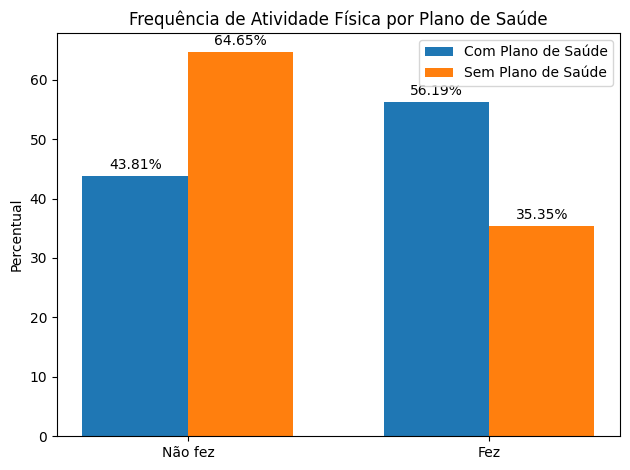

In [31]:
labels = ['Não fez', 'Fez']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [freq_atividade_plano.get(0, 0), freq_atividade_plano.get(1, 0)], width, label='Com Plano de Saúde')
rects2 = ax.bar(x + width/2, [freq_atividade_sem_plano.get(0, 0), freq_atividade_sem_plano.get(1, 0)], width, label='Sem Plano de Saúde')

ax.set_ylabel('Percentual')
ax.set_title('Frequência de Atividade Física por Plano de Saúde')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.2f%%' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [32]:
freq_fumante_plano = df_plano_saude['fumante'].value_counts(normalize=True) * 100
print("\nPercentual de pessoas com plano de saúde que são fumantes:")
print(freq_fumante_plano)

freq_fumante_sem_plano = df_sem_plano_saude['fumante'].value_counts(normalize=True) * 100
print("\nPercentual de pessoas SEM plano de saúde que são fumantes:")
print(freq_fumante_sem_plano)


Percentual de pessoas com plano de saúde que são fumantes:
fumante
0   92.05
1    7.95
Name: proportion, dtype: float64

Percentual de pessoas SEM plano de saúde que são fumantes:
fumante
0   86.13
1   13.87
Name: proportion, dtype: float64


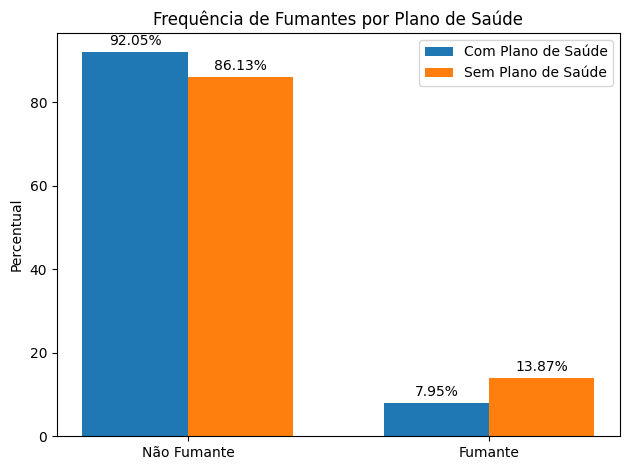

In [33]:
# prompt: Fazer 2 gráficos para estatistica acima de fumantes, e adicione a % no topo da barra

labels_fumante = ['Não Fumante', 'Fumante']
x_fumante = np.arange(len(labels_fumante))
width_fumante = 0.35

fig_fumante, ax_fumante = plt.subplots()
rects1_fumante = ax_fumante.bar(x_fumante - width_fumante/2, [freq_fumante_plano.get(0, 0), freq_fumante_plano.get(1, 0)], width_fumante, label='Com Plano de Saúde')
rects2_fumante = ax_fumante.bar(x_fumante + width_fumante/2, [freq_fumante_sem_plano.get(0, 0), freq_fumante_sem_plano.get(1, 0)], width_fumante, label='Sem Plano de Saúde')

ax_fumante.set_ylabel('Percentual')
ax_fumante.set_title('Frequência de Fumantes por Plano de Saúde')
ax_fumante.set_xticks(x_fumante)
ax_fumante.set_xticklabels(labels_fumante)
ax_fumante.legend()

def autolabel_fumante(rects):
    for rect in rects:
        height = rect.get_height()
        ax_fumante.annotate('%.2f%%' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel_fumante(rects1_fumante)
autolabel_fumante(rects2_fumante)

fig_fumante.tight_layout()

plt.show()

In [34]:
freq_fumante_plano = df_plano_saude['internacoes_12_meses'].value_counts(normalize=True) * 100
print("\nPercentual de pessoas com plano de saúde que foram internadas nos últimos 12 meses:")
print(freq_fumante_plano)

freq_fumante_sem_plano = df_sem_plano_saude['internacoes_12_meses'].value_counts(normalize=True) * 100
print("\nPercentual de pessoas SEM plano de saúde que foram internadas nos últimos 12 meses:")
print(freq_fumante_sem_plano)


Percentual de pessoas com plano de saúde que foram internadas nos últimos 12 meses:
internacoes_12_meses
0   90.19
1    9.81
Name: proportion, dtype: float64

Percentual de pessoas SEM plano de saúde que foram internadas nos últimos 12 meses:
internacoes_12_meses
0   92.94
1    7.06
Name: proportion, dtype: float64


In [35]:
# Gráfico de Barras para Frequência de Saúde Subjetiva
freq_saude_plano = df_plano_saude['saude_subjetivo'].value_counts(normalize=True).sort_index() * 100
print("\nPercentual de pessoas com plano de saúde pela saúde subjetiva:")
print(freq_saude_plano)

freq_saude_sem_plano = df_sem_plano_saude['saude_subjetivo'].value_counts(normalize=True).sort_index() * 100
print("\nPercentual de pessoas SEM plano de saúde pela saúde subjetiva:")
print(freq_saude_sem_plano)


Percentual de pessoas com plano de saúde pela saúde subjetiva:
saude_subjetivo
0    0.60
1    2.54
2   20.50
3   53.88
4   22.47
Name: proportion, dtype: float64

Percentual de pessoas SEM plano de saúde pela saúde subjetiva:
saude_subjetivo
0    1.49
1    6.28
2   33.72
3   48.02
4   10.49
Name: proportion, dtype: float64


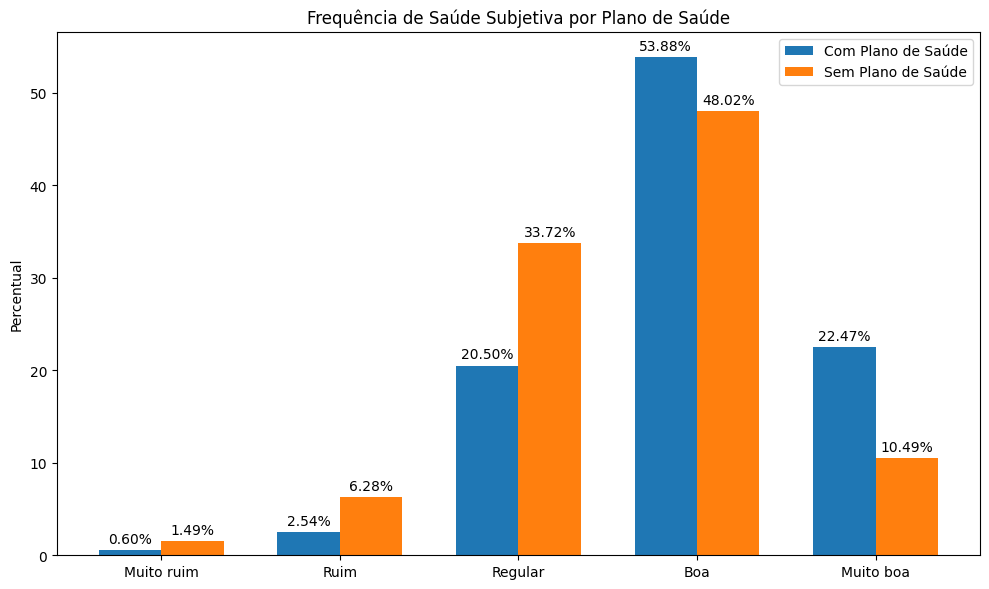

In [36]:
labels_saude = ['Muito ruim', 'Ruim', 'Regular', 'Boa', 'Muito boa']
x_saude = np.arange(len(labels_saude))
width_saude = 0.35

fig_saude, ax_saude = plt.subplots(figsize=(10, 6))
rects1_saude = ax_saude.bar(x_saude - width_saude/2, [freq_saude_plano.get(i, 0) for i in range(5)], width_saude, label='Com Plano de Saúde')
rects2_saude = ax_saude.bar(x_saude + width_saude/2, [freq_saude_sem_plano.get(i, 0) for i in range(5)], width_saude, label='Sem Plano de Saúde')

ax_saude.set_ylabel('Percentual')
ax_saude.set_title('Frequência de Saúde Subjetiva por Plano de Saúde')
ax_saude.set_xticks(x_saude)
ax_saude.set_xticklabels(labels_saude)
ax_saude.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax_saude.annotate('%.2f%%' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,
                            3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')



autolabel(rects1_saude)
autolabel(rects2_saude)

fig_saude.tight_layout()

plt.show()

In [37]:
# prompt: Média de renda per capita de pessoas com plano e sem plano de saúde

# Média de renda per capita por plano de saúde
mean_renda_plano = df_plano_saude['renda_domiciliar_per_capita'].mean()
mean_renda_sem_plano = df_sem_plano_saude['renda_domiciliar_per_capita'].mean()

print(f"\nMédia de renda per capita para pessoas com plano de saúde: R$ {mean_renda_plano:.2f}")
print(f"Média de renda per capita para pessoas sem plano de saúde: R$ {mean_renda_sem_plano:.2f}")


Média de renda per capita para pessoas com plano de saúde: R$ 3583.88
Média de renda per capita para pessoas sem plano de saúde: R$ 1013.76



Média de renda per capita para pessoas com plano de saúde: R$ 3583.88
Média de renda per capita para pessoas sem plano de saúde: R$ 1013.76


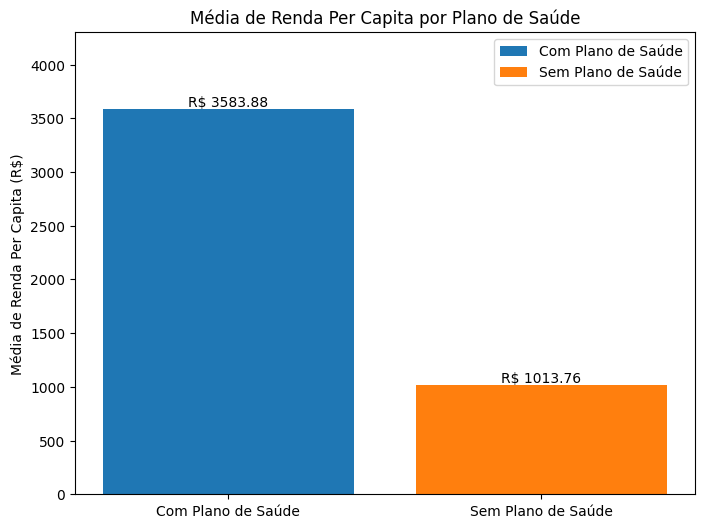

In [38]:
print(f"\nMédia de renda per capita para pessoas com plano de saúde: R$ {mean_renda_plano:.2f}")
print(f"Média de renda per capita para pessoas sem plano de saúde: R$ {mean_renda_sem_plano:.2f}")

labels_renda = ['Com Plano de Saúde', 'Sem Plano de Saúde']
medias_renda = [mean_renda_plano, mean_renda_sem_plano]

plt.figure(figsize=(8, 6))
# Usando as mesmas cores 'blue' e 'orange' dos gráficos anteriores
barras = plt.bar(labels_renda, medias_renda, color=['#1f77b4', '#ff7f0e'], label=labels_renda)
plt.ylabel('Média de Renda Per Capita (R$)')
plt.title('Média de Renda Per Capita por Plano de Saúde')

# Adiciona os valores nas barras
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2., yval, f'R$ {yval:.2f}', ha='center', va='bottom')

plt.ylim(0, max(medias_renda) * 1.2) # Ajusta o limite do eixo y para melhor visualização
plt.legend() # Adiciona a legenda
plt.show()


# Tratamento para Modelos

In [39]:
df.drop('estrato', axis=1, inplace=True)

In [40]:
# prompt: fazer dummies de todas as variaveis de objeto

# Create dummy variables for object type columns
object_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=object_cols, dummy_na=False) # dummy_na=False avoids creating dummy for NaN values

print("DataFrame after creating dummy variables:")
df.head()

DataFrame after creating dummy variables:


,idade,plano_saude,qtd_consultas_12_meses,internacoes_12_meses,saude_subjetivo,atividade_fisica_3_meses,fumante,hipertensao,diagnostico_diabetes,diagnostico_colesterol,doenca_cardiaca,avc,asma,dor_coluna,depressao,ansiedade,instrucao,renda_domiciliar_per_capita,uf_AC,uf_AL,uf_AM,uf_AP,uf_BA,uf_CE,uf_DF,uf_ES,uf_GO,uf_MA,uf_MG,uf_MS,uf_MT,uf_PA,uf_PB,uf_PE,uf_PI,uf_PR,uf_RJ,uf_RN,uf_RO,uf_RR,uf_RS,uf_SC,uf_SE,uf_SP,uf_TO,tipo_area_Capital,tipo_area_RIDE,tipo_area_Resto da RM,tipo_area_Resto da UF,sexo_Homem,sexo_Mulher,cor_raca_Amarela,cor_raca_Branca,cor_raca_Ignorado,cor_raca_Indígena,cor_raca_Parda,cor_raca_Preta
5048,50,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,5,600.00,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False
5049,15,0,0,0,3,1,0,0,0,0,0,0,0,1,0,0,2,87.00,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False
5050,38,1,2,0,3,0,0,0,0,0,0,0,0,0,0,0,4,500.00,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False
5051,61,0,2,0,2,1,0,0,0,0,0,0,0,1,0,0,1,665.00,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False
5052,36,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,4,567.00,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False


In [41]:
df.shape

(90846, 57)

# PNS

Optimization terminated successfully.
         Current function value: 0.363862
         Iterations 7


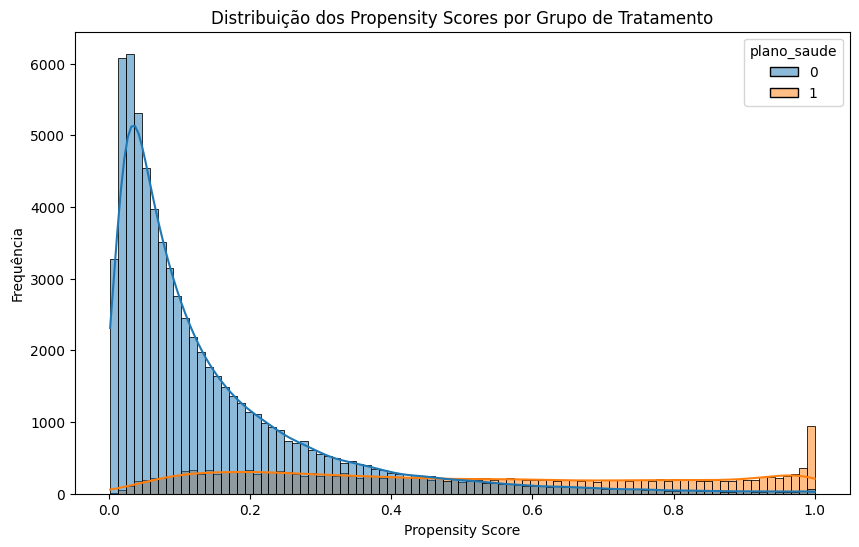

In [42]:
T = df['plano_saude']
X = df.drop(['plano_saude', 'saude_subjetivo'], axis=1)

X = sm.add_constant(X, has_constant='add')

logit_model = sm.Logit(T, X.astype(float))
result = logit_model.fit()

df['propensity_score'] = result.predict(X.astype(float))

plt.figure(figsize=(10, 6))
sns.histplot(df, x='propensity_score', hue='plano_saude', kde=True)
plt.title('Distribuição dos Propensity Scores por Grupo de Tratamento')
plt.xlabel('Propensity Score')
plt.ylabel('Frequência')
plt.show()

# Balanceamento

In [43]:
# prompt: balancear os dados, entre pessoas que tem e que não tem plano de saúde

from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.plano_saude==0]
df_minority = df[df.plano_saude==1]

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority), # to match minority class size
                                   random_state=42) # reproducible results

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
print("Class distribution after balancing:")
print(df_balanced.plano_saude.value_counts())

# Verify shapes
print("\nShape of original DataFrame:", df.shape)
print("Shape of balanced DataFrame:", df_balanced.shape)


Class distribution after balancing:
plano_saude
0    20568
1    20568
Name: count, dtype: int64

Shape of original DataFrame: (90846, 58)
Shape of balanced DataFrame: (41136, 58)


         Current function value: 0.457501
         Iterations: 35


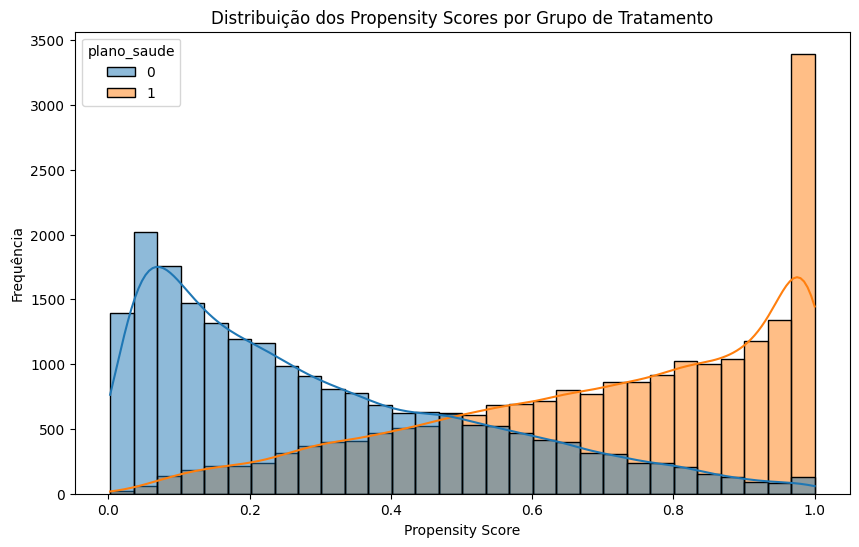

In [44]:
T = df_balanced['plano_saude']
X = df_balanced.drop(['plano_saude', 'saude_subjetivo'], axis=1)

X = sm.add_constant(X, has_constant='add')

logit_model = sm.Logit(T, X.astype(float))
result = logit_model.fit()

df_balanced['propensity_score'] = result.predict(X.astype(float))

plt.figure(figsize=(10, 6))
sns.histplot(df_balanced, x='propensity_score', hue='plano_saude', kde=True)
plt.title('Distribuição dos Propensity Scores por Grupo de Tratamento')
plt.xlabel('Propensity Score')
plt.ylabel('Frequência')
plt.show()

gráfico, a ampla região de sobreposição (especialmente entre 0.1 e 0.9, aproximadamente) indica que seu PSM foi bem-sucedido em encontrar indivíduos com e sem plano de saúde que possuem características observadas muito semelhantes.


Criação de Grupos Comparáveis: A ideia do PSM é criar "grupos de controle" (sem plano) que sejam tão parecidos quanto possível aos "grupos de tratamento" (com plano) em termos de todas as covariáveis observadas que poderiam influenciar tanto a decisão de ter um plano quanto a saúde subjetiva. Este gráfico mostra visualmente que você conseguiu isso para grande parte da sua amostra.


Redução de Viés: Ao ter grupos comparáveis, você minimiza o risco de que qualquer diferença na saúde subjetiva seja explicada por outras características (como idade, renda, etc.) e não pelo plano de saúde em si. Ou seja, você fortalece a sua capacidade de fazer inferências causais.

# Regressão Logistica


In [54]:
df_balanced

,idade,plano_saude,qtd_consultas_12_meses,internacoes_12_meses,saude_subjetivo,atividade_fisica_3_meses,fumante,hipertensao,diagnostico_diabetes,diagnostico_colesterol,doenca_cardiaca,avc,asma,dor_coluna,depressao,ansiedade,instrucao,renda_domiciliar_per_capita,uf_AC,uf_AL,uf_AM,uf_AP,uf_BA,uf_CE,uf_DF,uf_ES,uf_GO,uf_MA,uf_MG,uf_MS,uf_MT,uf_PA,uf_PB,uf_PE,uf_PI,uf_PR,uf_RJ,uf_RN,uf_RO,uf_RR,uf_RS,uf_SC,uf_SE,uf_SP,uf_TO,tipo_area_Capital,tipo_area_RIDE,tipo_area_Resto da RM,tipo_area_Resto da UF,sexo_Homem,sexo_Mulher,cor_raca_Amarela,cor_raca_Branca,cor_raca_Ignorado,cor_raca_Indígena,cor_raca_Parda,cor_raca_Preta,propensity_score
55983,52,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,250.00,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,True,False,False,False,False,0.13
132019,25,0,0,0,3,1,0,0,0,0,0,0,1,1,0,0,4,1675.00,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,True,False,False,False,False,0.43
243986,61,0,1,0,2,0,0,1,1,1,0,0,0,1,0,0,1,998.00,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,True,False,False,False,False,0.18
194432,23,0,2,0,3,1,0,0,0,0,0,0,0,0,0,0,5,2500.00,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,0.55
128416,32,0,2,0,2,0,0,1,0,1,0,0,0,0,0,0,1,175.00,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280126,63,1,2,0,2,0,0,1,0,1,1,0,0,1,0,0,6,2100.00,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,0.82
280127,52,1,4,1,3,1,0,0,0,1,0,0,0,0,0,0,6,5333.00,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,0.96
280129,52,1,6,0,2,0,0,1,0,0,0,0,0,0,1,0,6,7250.00,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,0.98
280130,39,1,3,0,4,1,0,0,0,0,0,0,0,0,0,0,6,10000.00,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,1.00


In [ ]:
# prompt: transforar tudo em flaot

for col in df_balanced.columns:
    if df_balanced[col].dtype != 'float64':
        df_balanced[col] = df_balanced[col].astype(float)

In [114]:
%%time
mod_prob = OrderedModel(df_balanced['saude_subjetivo'],
                        df_balanced[['idade', 'plano_saude', 'qtd_consultas_12_meses',
                        'internacoes_12_meses', 'atividade_fisica_3_meses', 'fumante',
                        'hipertensao', 'diagnostico_diabetes', 'diagnostico_colesterol',
                        'doenca_cardiaca', 'avc', 'asma', 'dor_coluna', 'depressao',
                        'ansiedade', 'instrucao', 'renda_domiciliar_per_capita', 'uf_AC',
                        'uf_AL', 'uf_AM', 'uf_AP', 'uf_BA', 'uf_CE', 'uf_DF', 'uf_ES', 'uf_GO',
                        'uf_MA', 'uf_MG', 'uf_MS', 'uf_MT', 'uf_PA', 'uf_PB', 'uf_PE', 'uf_PI',
                        'uf_PR', 'uf_RJ', 'uf_RN', 'uf_RO', 'uf_RR', 'uf_RS', 'uf_SC', 'uf_SE',
                        'uf_SP', 'tipo_area_Capital', 'tipo_area_RIDE', #'uf_TO'
                        'tipo_area_Resto da RM', 'sexo_Homem', #'tipo_area_Resto da UF',
                        'cor_raca_Amarela', 'cor_raca_Branca', # 'sexo_Mulher'
                        'cor_raca_Ignorado', 'cor_raca_Indígena', 'cor_raca_Parda ']],

                        distr='probit')

res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

         Current function value: 1.004182
         Iterations: 18
         Function evaluations: 81
         Gradient evaluations: 73


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:        saude_subjetivo   Log-Likelihood:                -41308.
Model:                   OrderedModel   AIC:                         8.273e+04
Method:            Maximum Likelihood   BIC:                         8.321e+04
Date:                Fri, 20 Jun 2025                                         
Time:                        00:08:18                                         
No. Observations:               41136                                         
Df Residuals:                   41080                                         
Df Model:                          52                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
idade                          -0.0077      0.000    -19.764      0.000      -0.008      -0.007
plano_saude                     0.2822      0.014     20.510      0.000       0.255       0.309
qtd_consultas_12_meses         -0.0261      0.001    -21.658      0.000      -0.028      -0.024
internacoes_12_meses           -0.2685      0.021    -13.076      0.000      -0.309      -0.228
atividade_fisica_3_meses        0.2772      0.012     23.152      0.000       0.254       0.301
fumante                        -0.0457      0.018     -2.542      0.011      -0.081      -0.010
hipertensao                    -0.2529      0.014    -17.510      0.000      -0.281      -0.225
diagnostico_diabetes           -0.4393      0.021    -21.017      0.000      -0.480      -0.398
diagnostico_colesterol         -0.1582      0.016    -10.029      0.000      -0.189      -0.127
doenca_cardiaca                -0.3352      0.024    -13.704      0.000      -0.383      -0.287
avc                            -0.2382      0.039     -6.060      0.000      -0.315      -0.161
asma                           -0.2198      0.024     -9.020      0.000      -0.268      -0.172
dor_coluna                     -0.4305      0.014    -30.637      0.000      -0.458      -0.403
depressao                      -0.3456      0.019    -17.752      0.000      -0.384      -0.307
ansiedade                      -0.2607      0.024    -10.913      0.000      -0.307      -0.214
instrucao                       0.0939      0.004     26.190      0.000       0.087       0.101
renda_domiciliar_per_capita  2.715e-05   1.68e-06     16.125      0.000    2.38e-05    3.04e-05
uf_AC                          -0.0975      0.056     -1.752      0.080      -0.207       0.012
uf_AL                          -0.1132      0.053     -2.138      0.033      -0.217      -0.009
uf_AM                          -0.0164      0.051     -0.318      0.751      -0.117       0.084
uf_AP                          -0.1214      0.062     -1.950      0.051      -0.244       0.001
uf_BA                          -0.0507      0.050     -1.008      0.313      -0.149       0.048
uf_CE                          -0.0309      0.050     -0.617      0.537      -0.129       0.067
uf_DF                           0.0600      0.053      1.137      0.255      -0.043       0.164
uf_ES                           0.1092      0.050      2.203      0.028       0.012       0.206
uf_GO                           0.0942      0.052      1.814      0.070      -0.008       0.196
uf_MA                          -0.2509      0.050     -5.023      0.000      -0.349      -0.153
uf_MG                           0.3407      0.047      7.180      0.000       0.248       0.434
uf_MS                           0.1927      0.052      3.741      0.000       0.092       0.294
uf_MT                           0.0217      0.054      0.405      0.686      -0.084       